In [1]:
import dolfinx
import gmsh
import tqdm
import copy
import cmasher
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.interpolate
from scipy.interpolate import griddata
from scipy.ndimage import uniform_filter1d, gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.tri as mtri
import matplotlib.colors
import matplotlib.animation
import matplotlib.cm as cm
import matplotlib as mpl

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

from mpi4py import MPI
from Source_pf.Mesh import *
from Source_pf.Simulation import *
from Source_pf.VideoController import *

--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           d-19-15-3
  Local device:         mlx5_1
  Local port:           1
  CPCs attempted:       rdmacm, udcm
--------------------------------------------------------------------------


In [2]:
import matplotlib.cm as cm

In [3]:
CM = 1/2.54

def rcparams():
    mpl.style.use('default')
    # plt.style.use(['science', 'nature'])
    plt.rcParams.update({
        'savefig.format': 'pdf',

        'font.size': 8,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Helvetica',
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
        'text.usetex': False,
        
        'lines.linewidth':1.5,
        
        'figure.figsize': (8.5*CM, 8.5*CM*2/3),

        'xtick.direction': 'out',
        'xtick.top': False,
        'xtick.bottom': True,
        'xtick.minor.visible': False,
        'xtick.labelsize': 8,
        'xtick.minor.size': 2,
        'xtick.minor.width': 0.5,
        'xtick.major.pad': 3,
        'xtick.major.size': 3,
        'xtick.major.width': 1,
        
        'ytick.direction': 'out',
        'ytick.right': False,
        'ytick.left': True,
        'ytick.minor.visible': False,
        'ytick.labelsize': 8,
        'ytick.direction': 'out',
        'ytick.minor.size': 2,
        'ytick.minor.width': 0.5,
        'ytick.major.pad': 3,
        'ytick.major.size': 3,
        'ytick.major.width': 1,

        'axes.grid': False,
        'axes.edgecolor': 'black',
        'axes.facecolor': 'white',
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.titlesize': 8,
        'axes.titlepad': 5,
        'axes.labelsize': 8,
        'axes.linewidth': 1,
        
        'legend.fontsize': 8,
        
        'figure.facecolor': 'white',
        'figure.dpi': 200,
        
        'savefig.transparent': True
    })

rcparams()

In [4]:
rnaprofile = lambda x: 0.277384 - 0.00156433*x - 0.0146816*x**2 - 0.00317079*x**3 + 0.00204666*x**4 - 0.000344679*x**5 + 2.58265e-5*x**6 - 5.86922e-7*x**7 - 3.73715e-8*x**8 + 2.6403e-9*x**9 - 4.8109e-11*x**10

In [5]:
L_domain = 7
domain_parameters = DomainParameters(L = L_domain, dim=2)
mesh = Mesh(
    MPI.COMM_SELF,
    domain_parameters
)

parameters = Parameters(M=1000.0, dt=1.0e-2, x0=-5.0, χ=-0.01, c_out = 0.9)
simulation = Simulation(MPI.COMM_SELF, mesh, parameters)


In [6]:
triangles_x = mtri.Triangulation(
    np.hstack([simulation.mesh.geometry.x[:,0], simulation.mesh.geometry.x[:,0]]),
    np.hstack([simulation.mesh.geometry.x[:,1], -simulation.mesh.geometry.x[:,1]])
    )

In [8]:
for c_out in [0.9]:
    L_domain = 7
    domain_parameters = DomainParameters(L = L_domain, dim=2)
    mesh = Mesh(
        MPI.COMM_SELF,
        domain_parameters
    )

    parameters = Parameters(M=1000.0, dt=1.0e-2, x0=-5.0, χ=-0.01, c_out=c_out)
    simulation = Simulation(MPI.COMM_SELF, mesh, parameters)

    # assign values to m in lab frame
    x = simulation.m.function_space.tabulate_dof_coordinates()
    r = np.linalg.norm(x, axis=1)
    simulation.m.x.array[:] = rnaprofile(r)
    
    triangles_x = mtri.Triangulation(
    np.hstack([simulation.mesh.geometry.x[:,0], simulation.mesh.geometry.x[:,0]]),
    np.hstack([simulation.mesh.geometry.x[:,1], -simulation.mesh.geometry.x[:,1]])
    )
    
    # np.save(f'mesh_{c_out:.4f}',triangles_x)
    
    # set up pandas dataframe to store data
    data = pd.DataFrame()

    # set up callback function to get data
    def get_data():
        # make measurement
        tmp = pd.DataFrame([{
                "t": simulation.now.time,
                "x": simulation.get_position(),
                "V": simulation.get_volume(),
                "mass": simulation.get_total_mass(),
                "grad_m": simulation.get_gradient_m(),
                "grad_mu": simulation.get_chemical_potential_imbalance(),
            }])

        # assign to global pandas dataframe
        global data
        data = pd.concat([data, tmp], ignore_index=True)
    
    concentration_dict = {}
    def save_concentration_field():
        global concentration_dict
    
        # Get the current concentration field data (DOF values)
        concentration_field = simulation.now.fun.x.array[simulation._c_idx]
        
        # Store the concentration field in the dictionary, keyed by time
        concentration_dict[f"t_{simulation.now.time:.4f}"] = concentration_field
            
    simulation.run(5.0, max_timestep=0.1, callbacks=[get_data, save_concentration_field])
    np.savez(f'concentration_field_{c_out:.4f}.npz', **concentration_dict)

    data.to_pickle(f'dataframe_{c_out:.4f}.pkl')

100%|██████████| 5.0/5.0 [05:42<00:00, 68.48s/it]                  


  pairs_cmap = cm.get_cmap('Paired')



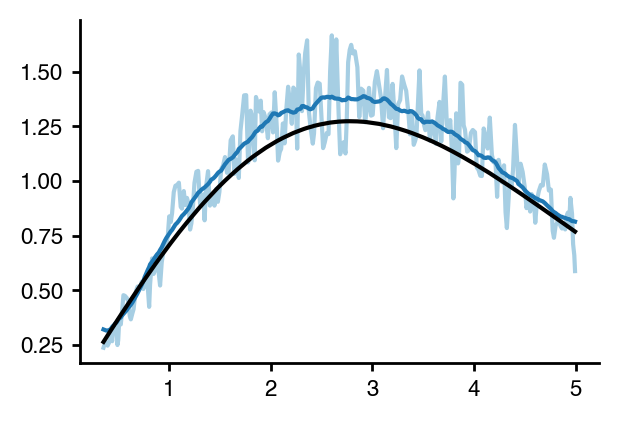

In [129]:
c_out = 0.1
data = pd.read_pickle(f'dataframe_{c_out:.4f}.pkl')
pairs_cmap = cm.get_cmap('Paired')
plt.plot(-data.x, np.gradient(data.x,data.t),color=pairs_cmap(0))
plt.plot(-data.x, uniform_filter1d(np.gradient(data.x,data.t),40),color=pairs_cmap(1))
plt.plot(-data.x, -domain_parameters.dim * parameters.M * parameters.χ / ((1 - c_out) * data.V) * data.grad_m, color="black")

  pairs_cmap = cm.get_cmap('Paired')



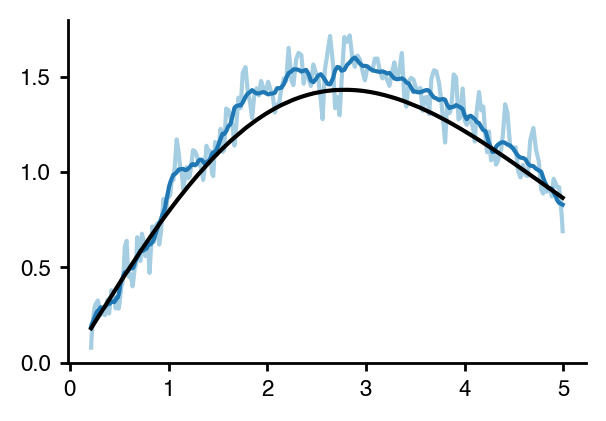

In [130]:
c_out = 0.2
data = pd.read_pickle(f'dataframe_{c_out:.4f}.pkl')
pairs_cmap = cm.get_cmap('Paired')
plt.plot(-data.x, np.gradient(data.x,data.t),color=pairs_cmap(0))
plt.plot(-data.x, uniform_filter1d(np.gradient(data.x,data.t),10),color=pairs_cmap(1))
plt.plot(-data.x, -domain_parameters.dim * parameters.M * parameters.χ / ((1 - c_out) * data.V) * data.grad_m, color="black")

  pairs_cmap = cm.get_cmap('Paired')



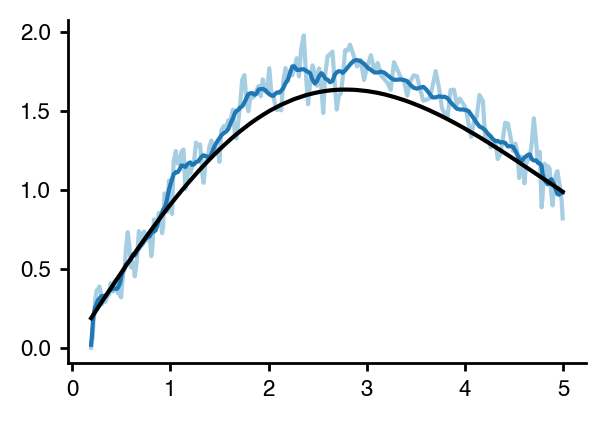

In [131]:
c_out = 0.3
data = pd.read_pickle(f'dataframe_{c_out:.4f}.pkl')
pairs_cmap = cm.get_cmap('Paired')
plt.plot(-data.x, np.gradient(data.x,data.t),color=pairs_cmap(0))
plt.plot(-data.x, uniform_filter1d(np.gradient(data.x,data.t),10),color=pairs_cmap(1))
plt.plot(-data.x, -domain_parameters.dim * parameters.M * parameters.χ / ((1 - c_out) * data.V) * data.grad_m, color="black")

  pairs_cmap = cm.get_cmap('Paired')



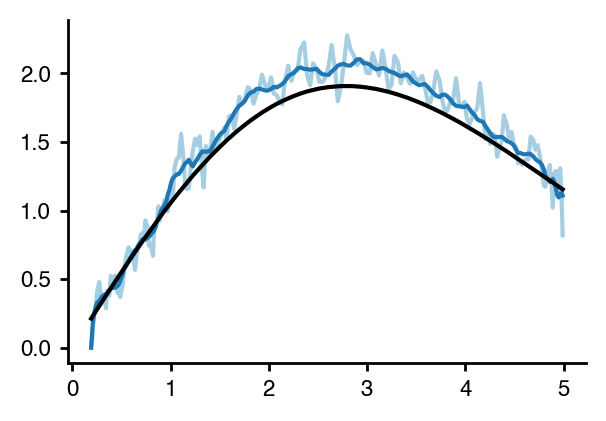

In [132]:
c_out = 0.4
data = pd.read_pickle(f'dataframe_{c_out:.4f}.pkl')
pairs_cmap = cm.get_cmap('Paired')
plt.plot(-data.x, np.gradient(data.x,data.t),color=pairs_cmap(0))
plt.plot(-data.x, uniform_filter1d(np.gradient(data.x,data.t),10),color=pairs_cmap(1))
plt.plot(-data.x, -domain_parameters.dim * parameters.M * parameters.χ / ((1 - c_out) * data.V) * data.grad_m, color="black")

  pairs_cmap = cm.get_cmap('Paired')



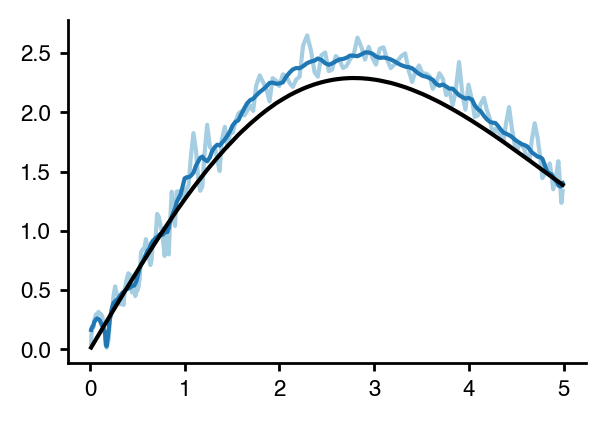

In [133]:
c_out = 0.5
data = pd.read_pickle(f'dataframe_{c_out:.4f}.pkl')
pairs_cmap = cm.get_cmap('Paired')
plt.plot(-data.x, np.gradient(data.x,data.t),color=pairs_cmap(0))
plt.plot(-data.x, uniform_filter1d(np.gradient(data.x,data.t),10),color=pairs_cmap(1))
plt.plot(-data.x, -domain_parameters.dim * parameters.M * parameters.χ / ((1 - c_out) * data.V) * data.grad_m, color="black")

  pairs_cmap = cm.get_cmap('Paired')



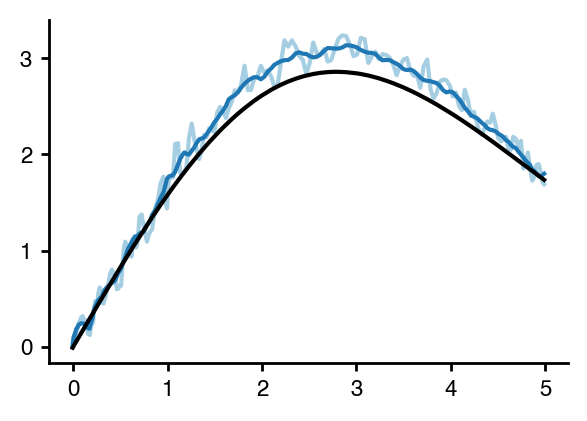

In [134]:
c_out = 0.6
data = pd.read_pickle(f'dataframe_{c_out:.4f}.pkl')
pairs_cmap = cm.get_cmap('Paired')
plt.plot(-data.x, np.gradient(data.x,data.t),color=pairs_cmap(0))
plt.plot(-data.x, uniform_filter1d(np.gradient(data.x,data.t),10),color=pairs_cmap(1))
plt.plot(-data.x, -domain_parameters.dim * parameters.M * parameters.χ / ((1 - c_out) * data.V) * data.grad_m, color="black")

  pairs_cmap = cm.get_cmap('Paired')



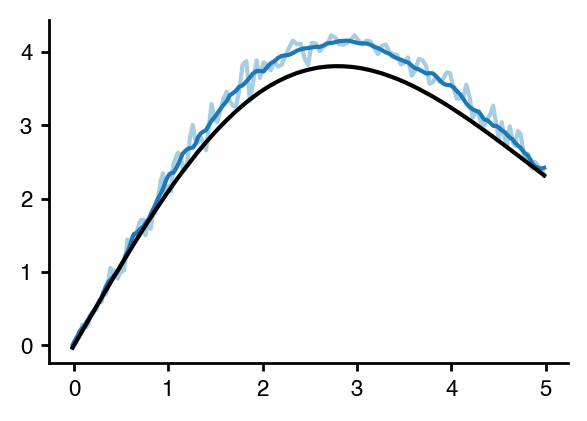

In [135]:
c_out = 0.7
data = pd.read_pickle(f'dataframe_{c_out:.4f}.pkl')
pairs_cmap = cm.get_cmap('Paired')
plt.plot(-data.x, np.gradient(data.x,data.t),color=pairs_cmap(0))
plt.plot(-data.x, uniform_filter1d(np.gradient(data.x,data.t),10),color=pairs_cmap(1))
plt.plot(-data.x, -domain_parameters.dim * parameters.M * parameters.χ / ((1 - c_out) * data.V) * data.grad_m, color="black")

  pairs_cmap = cm.get_cmap('Paired')



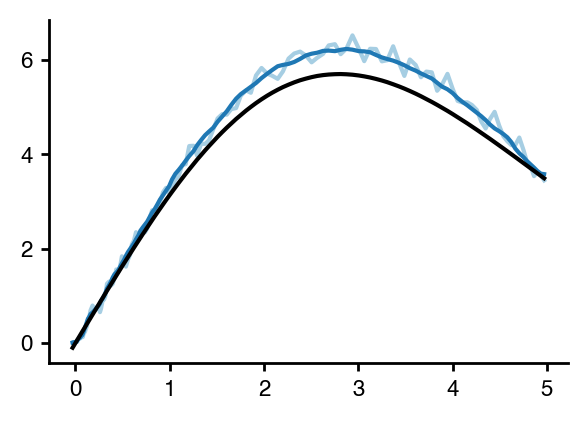

In [136]:
c_out = 0.8
data = pd.read_pickle(f'dataframe_{c_out:.4f}.pkl')
pairs_cmap = cm.get_cmap('Paired')
plt.plot(-data.x, np.gradient(data.x,data.t),color=pairs_cmap(0))
plt.plot(-data.x, uniform_filter1d(np.gradient(data.x,data.t),10),color=pairs_cmap(1))
plt.plot(-data.x, -domain_parameters.dim * parameters.M * parameters.χ / ((1 - c_out) * data.V) * data.grad_m, color="black")

  pairs_cmap = cm.get_cmap('Paired')



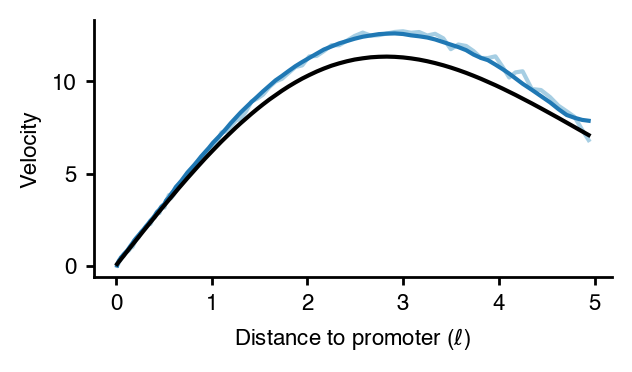

In [22]:
fig, ax = plt.subplots(figsize=(8.5*CM,8.5*CM/2))
c_out = 0.9
data = pd.read_pickle(f'dataframe_{c_out:.4f}.pkl')
pairs_cmap = cm.get_cmap('Paired')
ax.plot(-data.x, np.gradient(data.x,data.t),color=pairs_cmap(0))
ax.plot(-data.x, uniform_filter1d(np.gradient(data.x,data.t),10),color=pairs_cmap(1))
ax.plot(-data.x, -domain_parameters.dim * parameters.M * parameters.χ / ((1 - c_out) * data.V) * data.grad_m, color="black")
ax.set_xlabel("Distance to promoter ($\ell$)")
ax.set_ylabel("Velocity")
plt.savefig("circular.pdf")

In [13]:
data = np.load('concentration_field_0.9000.npz')

  ax.tricontourf(triangles_x, np.hstack([arr,arr]), levels=np.linspace(0.89,1,100), cmap="Blues", extend="max", zorder=1, aspect="1")



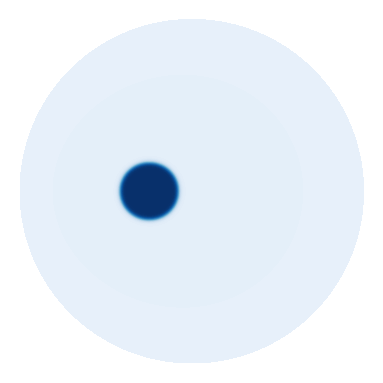

In [20]:
t = 40
arr = data[data.files[t]]
fig, ax = plt.subplots()
ax.tricontourf(triangles_x, np.hstack([arr,arr]), levels=np.linspace(0.89,1,100), cmap="Blues", extend="max", zorder=1, aspect="1")
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False)
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
ax.set_aspect(1)

In [16]:
x = simulation.mesh.geometry.x[:,0]
y = simulation.mesh.geometry.x[:,1]

In [17]:
aspect_lst = []
for i in data:
    arr = data[i]
    cond_x = x[arr>0.95]
    cond_y = y[arr>0.95]
    aspect_lst.append((cond_x.max()-cond_x.min())/(cond_y.max()*2))

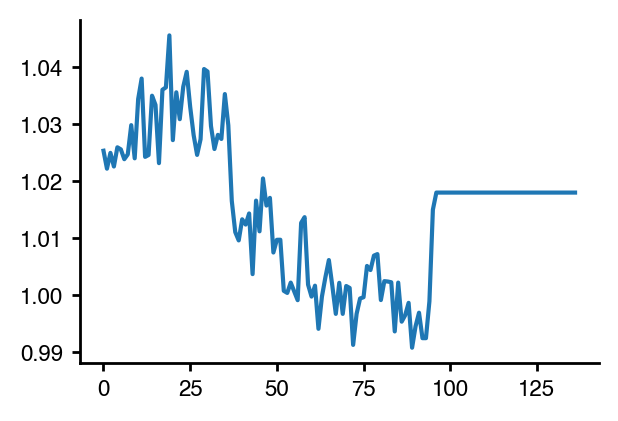

In [18]:
t = 80
fig, ax = plt.subplots()
ax.plot(aspect_lst)